Import Libraries

In [1]:
import numpy as np
import cv2
from os import path
from os import listdir
from os.path import isfile, join
import random
from matplotlib import pyplot as plt

In [2]:
# Define global variables

data_path = 'eigenface_dataset/upload_dataset/';
I = cv2.imread(path.join(data_path,'2b.jpg'),0)
mn = I.shape
m = I.shape[0]
n = I.shape[1]
M = 100 # Number of images in train set
k = np.arange(1,M+1,2) # Number of prinicipal components for (3) & (4)

Helper Function to read data the images and generate suitable matrices for furhter processing

In [3]:
def getData(N):
    '''
    Helper function to generate matrix of N images as 
    a matrix of MxN where M is total number of pixels
    in an image
    '''
    data_path = 'eigenface_dataset/upload_dataset/';

    I_size = mn
    MN = I_size[0]*I_size[1]

    # Creating a list of image paths corresponding to 'a' and 'b' category
    # a -> Neurtral
    # b -> Smiling
    image_set_a = [];
    image_set_b = [];
    onlyfiles = [join(data_path, f) for f in listdir(data_path) if isfile(join(data_path, f))]
    sorted(onlyfiles)
    for i in onlyfiles:
        if((i[-5] == 'a') & (i not in image_set_a)):
            image_set_a.append(i)
            i_b = i[0:-5] + 'b' + i[-4:]
            image_set_b.append(i_b)
        elif(i not in image_set_b):
            image_set_b.append(i)
            i_a = i[0:-5] + 'a' + i[-4:]
            image_set_a.append(i_a)
        
    trainData_a  = np.zeros((MN, N))
    testData_a = np.zeros((MN,171-N))
    
    trainData_b  = np.zeros((MN, N))
    testData_b = np.zeros((MN,171-N))
    
    idx_rp = random.sample(range(171), 171)
    img_idx = idx_rp[0:N]
    img_idx_test = idx_rp[N:-1]
    
    for i in range(len(img_idx)):
        trainData_a[:,i] = cv2.imread(image_set_a[img_idx[i]],0).reshape((MN,))
        trainData_b[:,i] = cv2.imread(image_set_b[img_idx[i]],0).reshape((MN,))
    for i in range(len(img_idx_test)):
        testData_a[:,i] = cv2.imread(image_set_a[img_idx_test[i]],0).reshape((MN,))
        testData_b[:,i] = cv2.imread(image_set_b[img_idx_test[i]],0).reshape((MN,))
        
    return trainData_a/255, testData_a/255, trainData_b/255, testData_b/255

Function to generate the A matrix and mean face.

In [4]:
def generateDataMatrix(data):
    meanFace = np.mean(data,1,keepdims=True)
    A = data - meanFace
    return meanFace, A

In [5]:
# Prepare dataset by splitting into test and train set
dataTrain_a, dataTest_a, dataTrain_b, dataTest_b = getData(M)
meanFace_a, A_a = generateDataMatrix(dataTrain_a)
meanFace_b, A_b = generateDataMatrix(dataTrain_b)

Generate eigen faces 

In [6]:
def generateEigenFaces(A):
    '''
    Helper function to generate M 
    eigenface from normalized face matrix.
    '''
    # Generate L using AT*A
    L = np.matmul(np.transpose(A),A)
    # Calculate eigenvectors and eigenvalues
    [l,e] = np.linalg.eigh(L)
    # sort eigenvectors and eigenvalues based on eigenvalue
    l = np.flip(l)# l[idx]#
    e = np.flip(e,1)# e[:,idx]#
    eigen_faces = np.matmul(A,e)
    # Normalize eigen faces
    eigen_faces = eigen_faces/np.linalg.norm(eigen_faces,2,axis=0)
    return eigen_faces,l

Helper function to plot K of the M eigenfaces

In [7]:
def plotKEigenFaces(eigen_faces, meanFace, K = 10):
    '''
    Helper function to plot K eigenfaces
    '''
    plt.figure(figsize=(20,20))
    plt.suptitle(str(K) + ' most representative eigen faces')
    eigen_faces = eigen_faces
    for i in range(K):
        ef = eigen_faces[:,i]
        I_ef = ef.reshape((m,n))
        plt.subplot(int(K/2),2,i+1)
        plt.imshow(I_ef, cmap='gray')
        plt.axis('off')
    plt.show()

Helper function to plot image

In [8]:
def plotImage(I, title):
    '''
    Plot image
    '''
    plt.imshow(I, cmap = 'gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

Function reconstructs given image and eigen faces

In [9]:
def reconstructFace(T,meanFace,eigenfaces):
    '''
    Given a face, project onto face space
    '''
    T_normalized = T - meanFace
    # Get its component along each eigenvector  
    w = np.matmul(eigenfaces.T,T_normalized)
    # Revonstruct face
    recon_face_v = np.matmul(eigenfaces,w) + meanFace
    return recon_face_v

Calculate MSE 

In [10]:
def calculateMSE(recon_face_v, T):
    '''
    Calculate MSE
    '''
    mse = np.square(T - recon_face_v)
    return np.mean(mse)

Run re-construction on given image and eigen faces using differnet number of prinicipal components

In [11]:
def runReconExp(T, eigen_faces, meanFace):
    '''
    Sweep across differnet number of prinicipal components.
    Plot each reconstructed eigenface and return MSE
    '''
        
    MSE_Error = np.zeros_like(k).astype(np.float64)
    plt.figure(figsize=(15,15))
    plt.suptitle('Reconstructed Faces')
    for i in range(k.shape[0]):
        K = k[i]
        
        recon_face_v = reconstructFace(T, meanFace, eigen_faces[:,np.arange(K)])

        # Calculate MSE
        MSE_Error[i] = calculateMSE(recon_face_v, T)

        recon_face = recon_face_v.reshape((m,n))

        plt.subplot(int(k.shape[0]/5),5,i+1)
        plt.imshow(recon_face, cmap = 'gray')
        plt.title(str(K))
        plt.axis('off')
    plt.show()
    return MSE_Error

Plot MSE 

In [12]:
def plotMSE(MSE_Error):
    '''
    Helper function to plot MSE
    '''
    plt.figure(figsize=(10,8))
    ax = plt.plot(MSE_Error)
    t = np.arange(0,k.shape[0]+1,2)
    plt.xticks(t, t*2)
    plt.title('MSE vs # Principal Components')
    plt.xlabel('Number of Prinicipal Components')
    plt.ylabel('Mean Squared Error')
    plt.show()

In [13]:
def calculateVariance(l):
    var = np.zeros_like(l)
    var[0] = l[0]
    for i in range(1,l.shape[0]):
        var[i] = l[i] + var[i-1]
    var = var/np.sum(l)
    return var

PA (1)\
Plot 10 most representative eigen faces of neutral face data-set

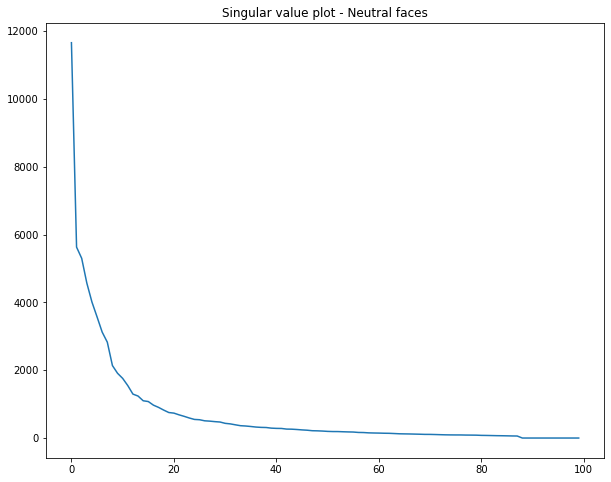

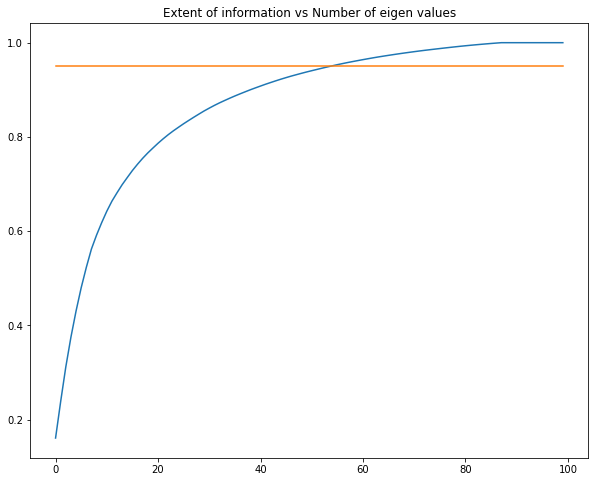

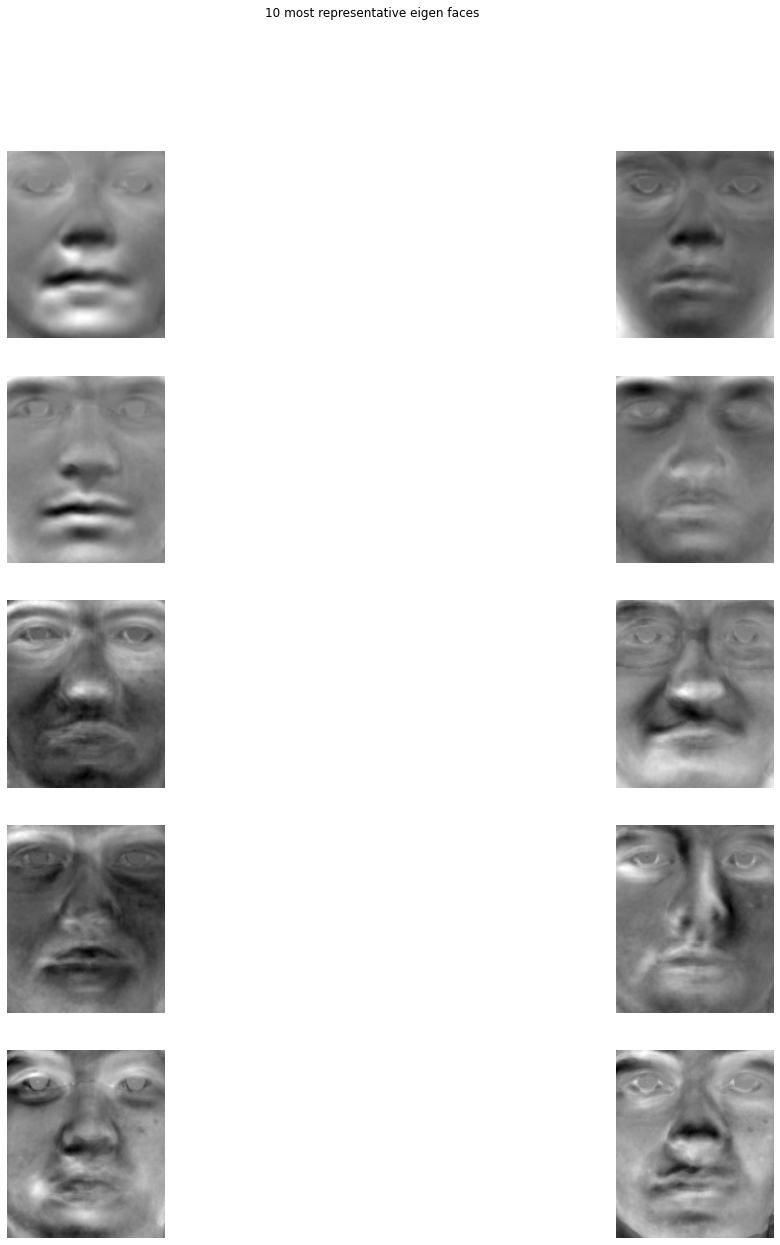

In [14]:
eigen_faces_a,l = generateEigenFaces(A_a)

e_a = calculateVariance(l)

plt.figure(figsize=(10,8))
plt.plot(l)
plt.title('Singular value plot - Neutral faces')

plt.figure(figsize=(10,8))
plt.plot(e_a)
plt.plot(np.ones_like(e_a)*.95)
plt.title('Extent of information vs Number of eigen values')

plotKEigenFaces(eigen_faces_a, meanFace_a, 10)

PA (1)\
Plot 10 most representative eigen faces of smiling face data-set

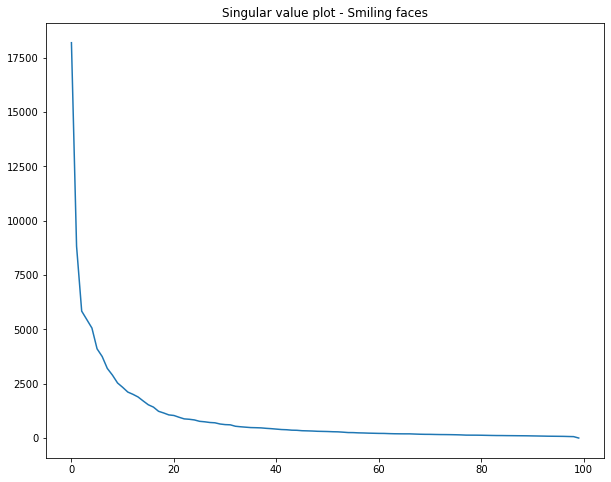

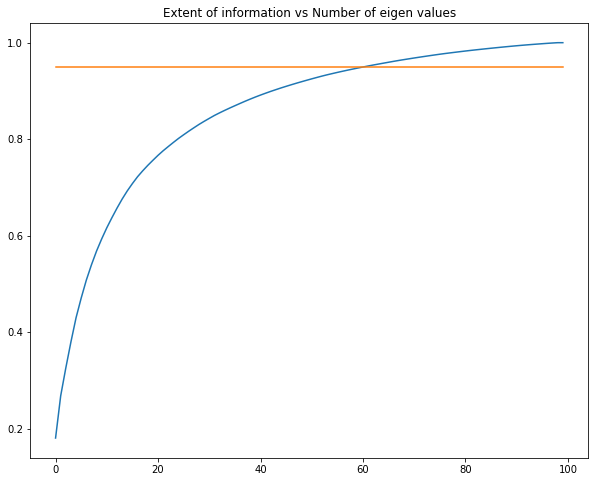

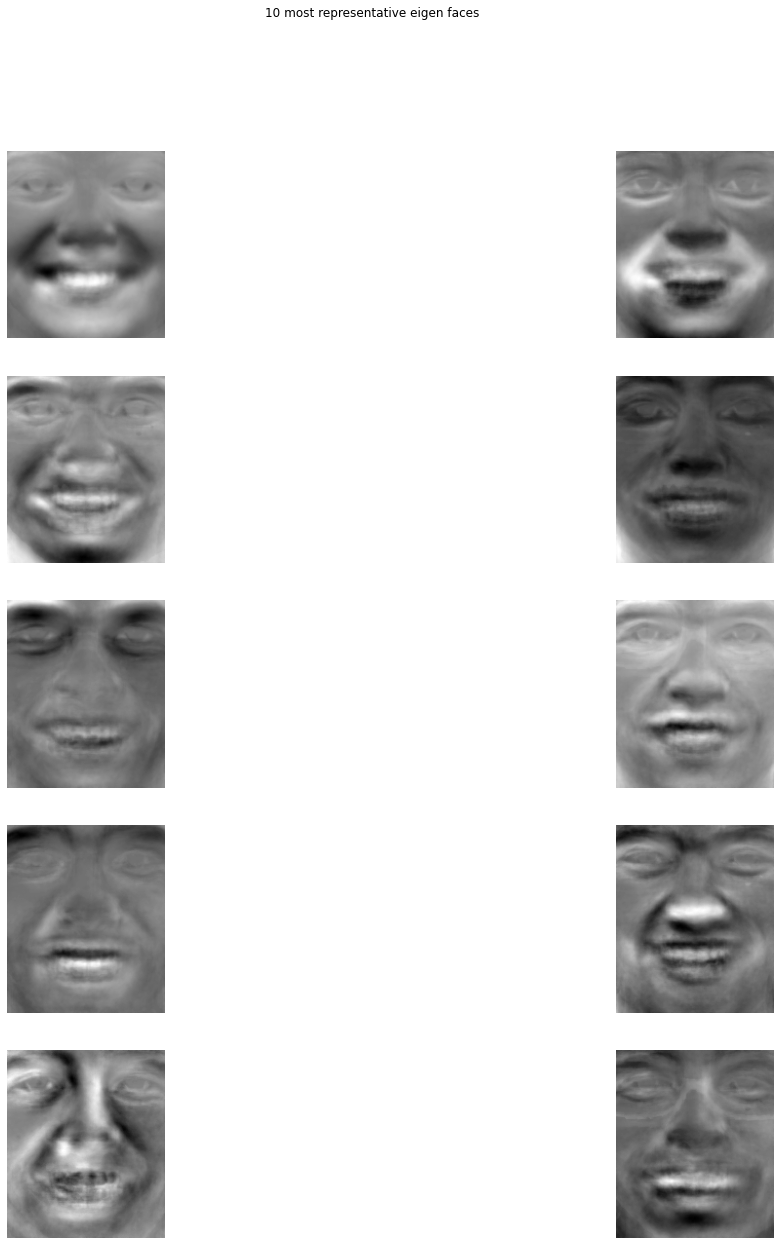

In [15]:
eigen_faces_b, l = generateEigenFaces(A_b)

plt.figure(figsize=(10,8))
plt.plot(l)
plt.title('Singular value plot - Smiling faces')

e_b = calculateVariance(l)

plt.figure(figsize=(10,8))
plt.plot(e_b)
plt.plot(np.ones_like(e_b)*.95)
plt.title('Extent of information vs Number of eigen values')

plotKEigenFaces(eigen_faces_b, meanFace_b, 10)

In [16]:
m_a = np.argmax(e_a>0.95)
m_b = np.argmax(e_b>0.95)
print(m_a)
print(m_b)

54
61


PA(1)\
The singular value plots indicate that the first few eigenvectors have comparatively larger eigenvalues assosciated with them. Each eigen value corresponding to each eigen vector can be intuitively though of as the extent of data or the variance assoscaited with that direction.

I chose k = 54 eigen faces for the neutral face dataset and k = 61 for the smiling face dataset to represent the 2 subspaces respectively. These numbers for the 2 classes is selected on the following formula with T = 0.95

$\dfrac{\left( \sum_{i = 1}^{k} \lambda_{i} \right)}{\left( \sum_{i = 1}^{M = 100} \lambda_{i} \right)} \geq 0.95$

This esentially finds the set of eigenfaces that capture 95% of the information captured in the data matrix

Corresponding plots for this is plotted above

In [17]:
eigen_faces_a_basis = eigen_faces_a[:,range(m_a)]
eigen_faces_b_basis = eigen_faces_b[:,range(m_b)]

PA(2)\
Reconstruct training image from neutral faces

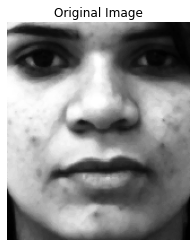

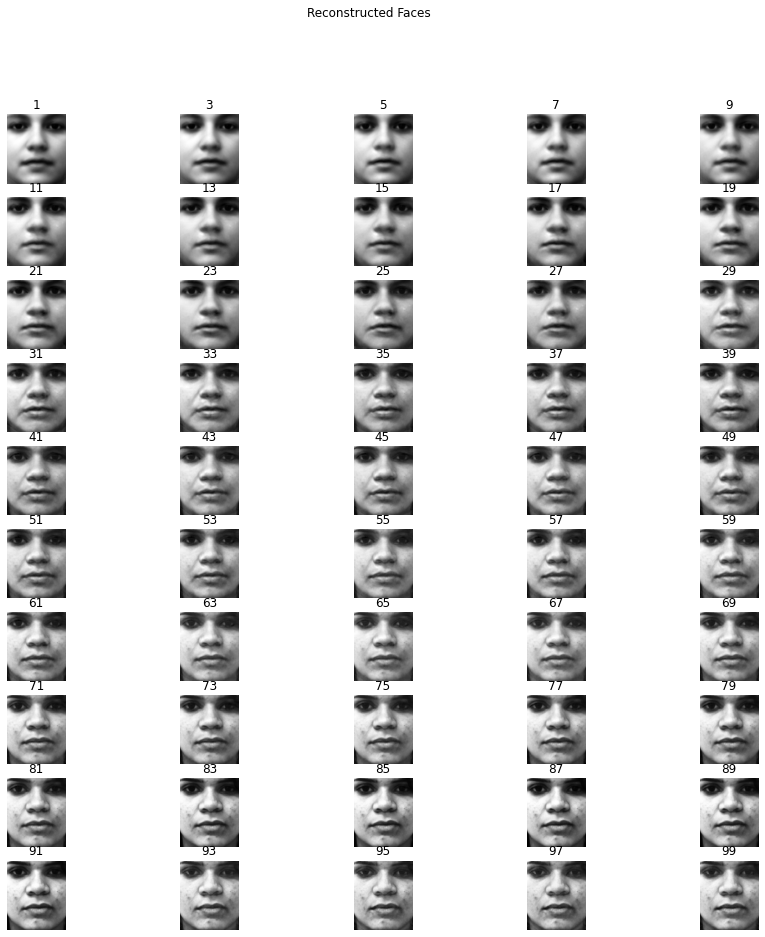

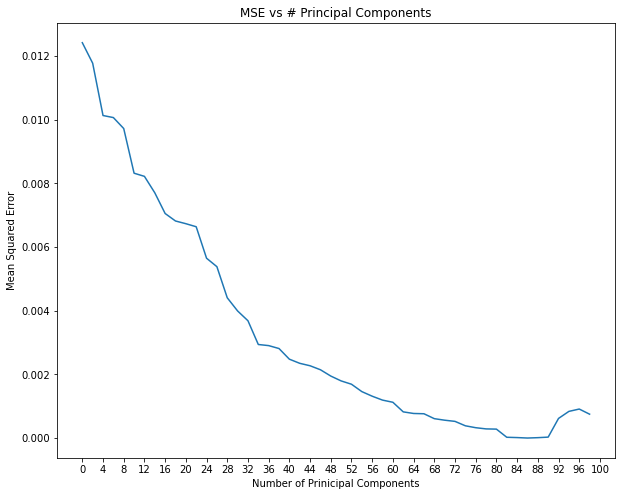

In [18]:
# Pick a training Image
T = dataTrain_a[:,[0]]
og_face = T.reshape((m,n))

# Original image
plotImage(og_face, 'Original Image')

# Reconstruct using differnent number of components
MSE_Error = runReconExp(T, eigen_faces_a, meanFace_a)

# Plot Error
plotMSE(MSE_Error)

PA(2)\
Reconstruct training image from smiling faces

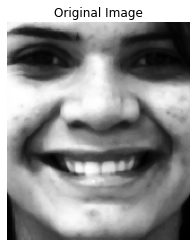

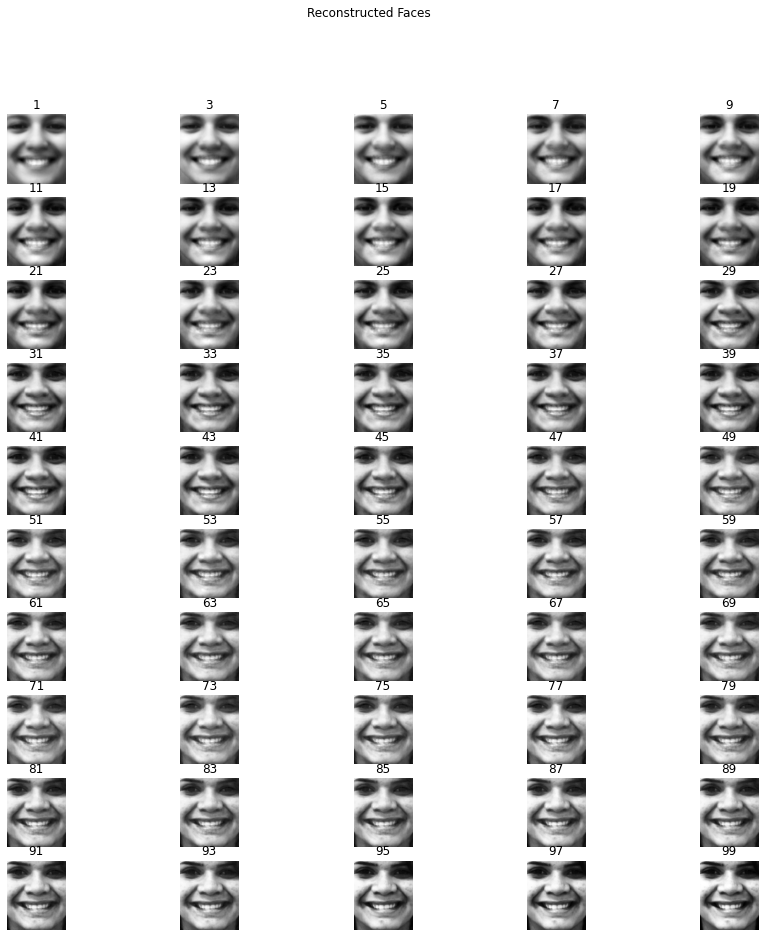

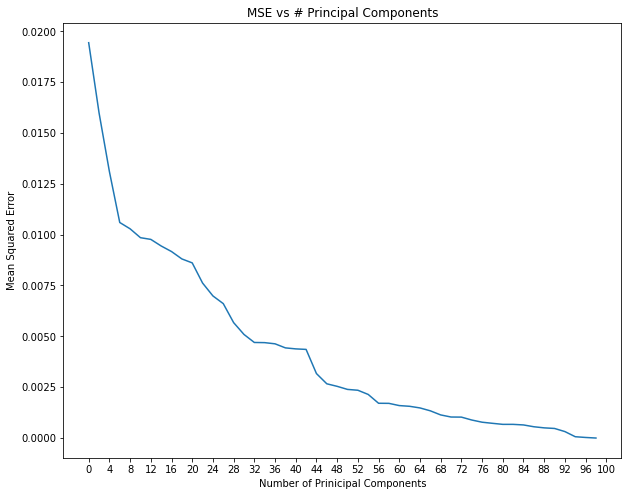

In [19]:
# Pick a training Image
T = dataTrain_b[:,[0]]
og_face = T.reshape((m,n))

# Original image
plotImage(og_face, 'Original Image')

# Reconstruct using differnent number of components
MSE_Error = runReconExp(T, eigen_faces_b, meanFace_b)

# Plot Error
plotMSE(MSE_Error)

PA(2)\
Reconstruct test image from neutral faces

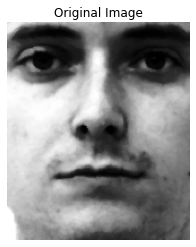

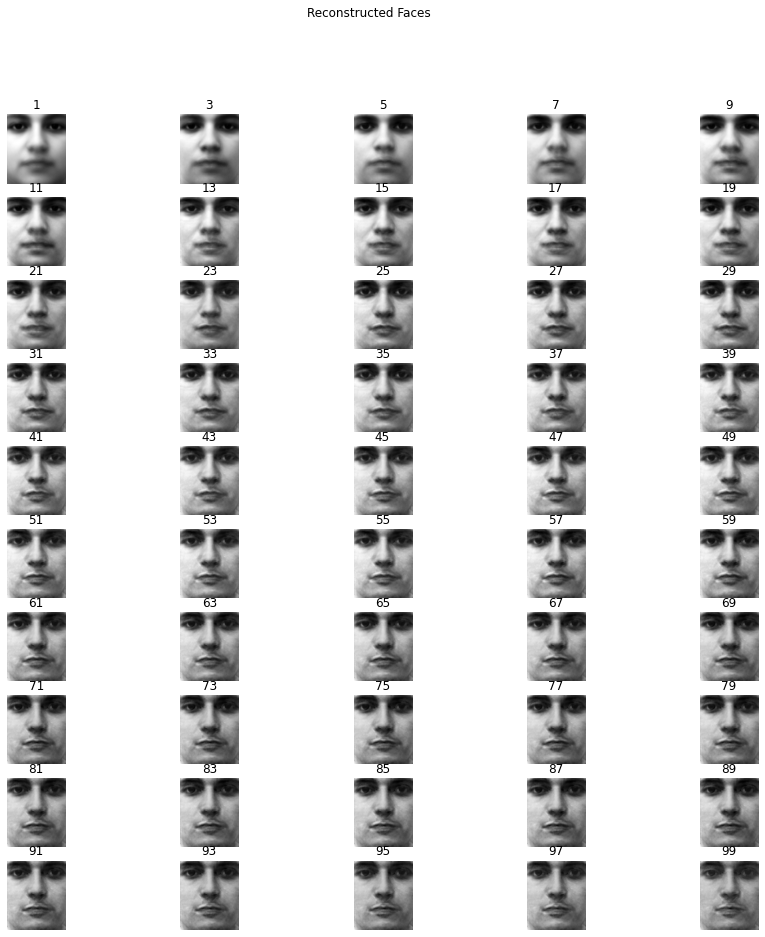

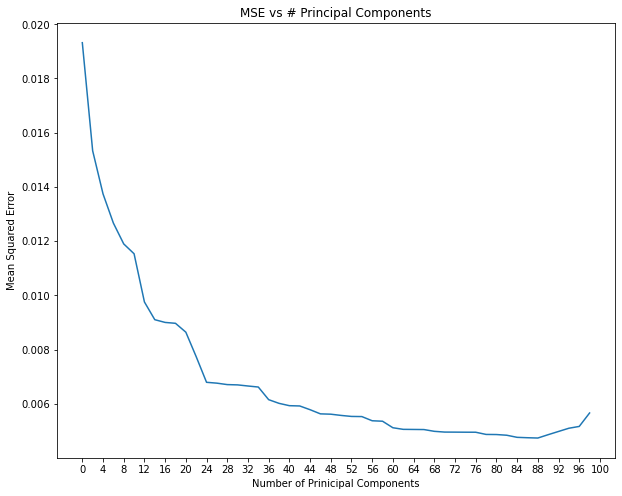

In [20]:
# Pick a training Image
T = dataTest_a[:,[0]]
og_face = T.reshape((m,n))

# Original image
plotImage(og_face, 'Original Image')

# Reconstruct using differnent number of components
MSE_Error = runReconExp(T, eigen_faces_a, meanFace_a)

# Plot Error
plotMSE(MSE_Error)

PA(2)\
Reconstruct test image from smiling faces

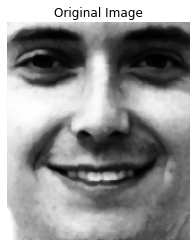

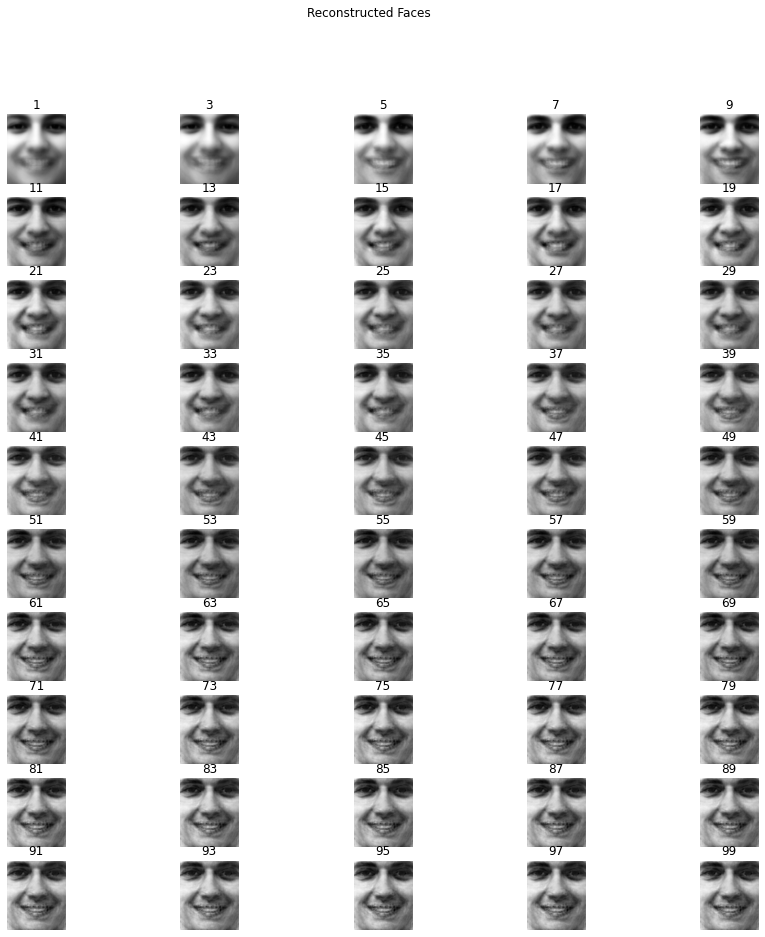

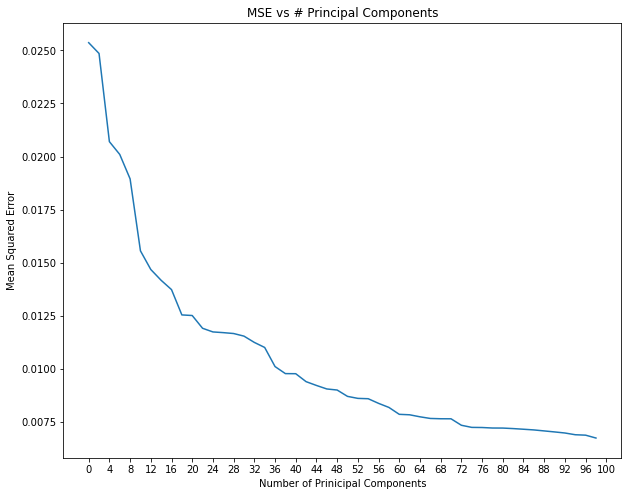

In [21]:
# Pick a training Image
T = dataTest_b[:,[0]]
og_face = T.reshape((m,n))

# Original image
plotImage(og_face, 'Original Image')

# Reconstruct using differnent number of components
MSE_Error = runReconExp(T, eigen_faces_b, meanFace_b)

# Plot Error
plotMSE(MSE_Error)

PA(2,3,4)
The plots of the reconstruction error with number of components show similar trends across the 2 classes (and across test and training data). As evident from the plot, the MSE of the reconstructed face reduces as the number of prinicpal components increases and saturates after a certain point (approx 50). This is approximately number of eigen faces that capture a majority of the subspace. More principal components beyond this point add very little information and hence the error rate saturates.
The difference across test set and trainig set experiments is the absolute MSE values. As expected, the error is more for test set when a totally new face is reconstructed.

PA(5a)\
Generate 60 test images from data not used for training. First 60 images are neutral faces, last 60 are smiling faces

In [22]:
# Create data for testing.
testData = np.concatenate([dataTrain_a[:,range(60)], dataTrain_b[:,range(60)]], axis = 1)

# Ground truth = 
gtLabels = np.hstack([np.ones((1,60)), np.zeros((1,60))])

PA(5b,c,d)\
Classify test image as smiling (0) or neutral(1)

In [23]:
predicted_labels = np.ones_like(gtLabels)*-1;
for i in range(120):
    # Predict on ith test image
    T = testData[:,[i]]
    # Find projections on 2 face space
    proj_a = reconstructFace(T,meanFace_a,eigen_faces_a_basis)
    proj_b = reconstructFace(T,meanFace_b,eigen_faces_b_basis)
    
    # Calculate MSE
    MSE_a = calculateMSE(proj_a, T)
    MSE_b = calculateMSE(proj_b, T)
    
    #print(MSE_a, MSE_b)
    if(MSE_a < MSE_b):
        # Predicted as neutral image
        predicted_labels[0,i] = 1;
    else:
        # Predicted as smiling image
        predicted_labels[0,i] = 0;

PA(5e)\
Measure classification accuracy

In [24]:
# Classification accuracy wrt neutral class
n_correct_a = np.sum(predicted_labels[0,range(60)] == 1)

# Classification accuracy wrt smiling class
n_correct_b = np.sum(predicted_labels[0,range(60,120)] == 0)

acc_a = n_correct_a/60*100
acc_b = n_correct_b/60*100

print('Accuracy w.r.t Neutral Face class ->' + str(acc_a))
print('Accuracy w.r.t Smiling Face class ->' + str(acc_b))

# Overall accuracy
n_correct_total = np.sum(predicted_labels == gtLabels)
acc_t = n_correct_total/120*100
print('Total classification accuracy ->' + str(acc_t))

Accuracy w.r.t Neutral Face class ->98.33333333333333
Accuracy w.r.t Smiling Face class ->85.0
Total classification accuracy ->91.66666666666666


PA(5f)
Plot mis-classified image

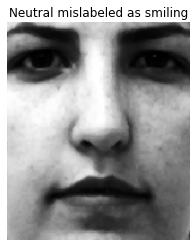

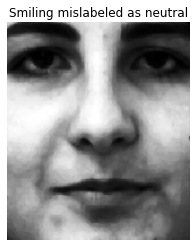

In [25]:
# Neutral face mislabeled as smiling
idx_mis_a = np.where(predicted_labels[0,range(60)] == 0)
img = testData[:,[idx_mis_a[0][0]]]
plotImage(img.reshape(m,n), 'Neutral mislabeled as smiling')

# Smiling face mislabeled as neutral
idx_mis_b = np.where(predicted_labels[0,range(60,120)] == 1)
img = testData[:,[idx_mis_b[0][0]+60]]
plotImage(img.reshape(m,n), 'Smiling mislabeled as neutral')

The misclassification in this case is because of the similarity in the 2 photos, i.e. both neutral and smiling expression look similar.

A possible way to improve the performance is to capture more faces across the classes in the test set to generate a better basis approximation of the 2 face-spaces (sub-spaces). 

Selecting more eigen faces as the basis might also help, but the algorithm may still fail in such cases where the 2 class photos are very similar